In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(ggpattern)
require(ggpubr)
require(pbapply)
pboptions(type="timer")

source("functions/plot_scatterplot_with_density_snr_value.R")

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: data.table

Loading required package: ggplot2

Loading required package: ggpattern

Loading required namespace: memoise

Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Loading required package: pbapply

Loading required package: ggforce



In [2]:
nthreads=10

In [3]:
dots_data0 = readRDS(file.path("/mnt/data/Imaging/202105-Deconwolf/data_210726",
                              "dots_data.rds"))[is.finite(SNR2) & SNR2 > 0 & Value2 > 0]
nuclear_features = fread("../data/selected_nuclei.tsv", key=c("sid", "nid"))

In [4]:
dots_data = rbindlist(pblapply(split(dots_data0, list(dots_data0$image_type, dots_data0$magnification)), function(subdata, nuclear_features) {
    setkeyv(subdata, c("series_id", "nid"))
    return(nuclear_features[subdata][!is.na(size)])
}, nuclear_features))
setnames(dots_data, "sid", "series_id")

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=09s  


# Panel 3.e
Scatterplot of Value (Y) and SNR (X) for 60x.dw, field 1. Density of Value on the side of Y panel.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



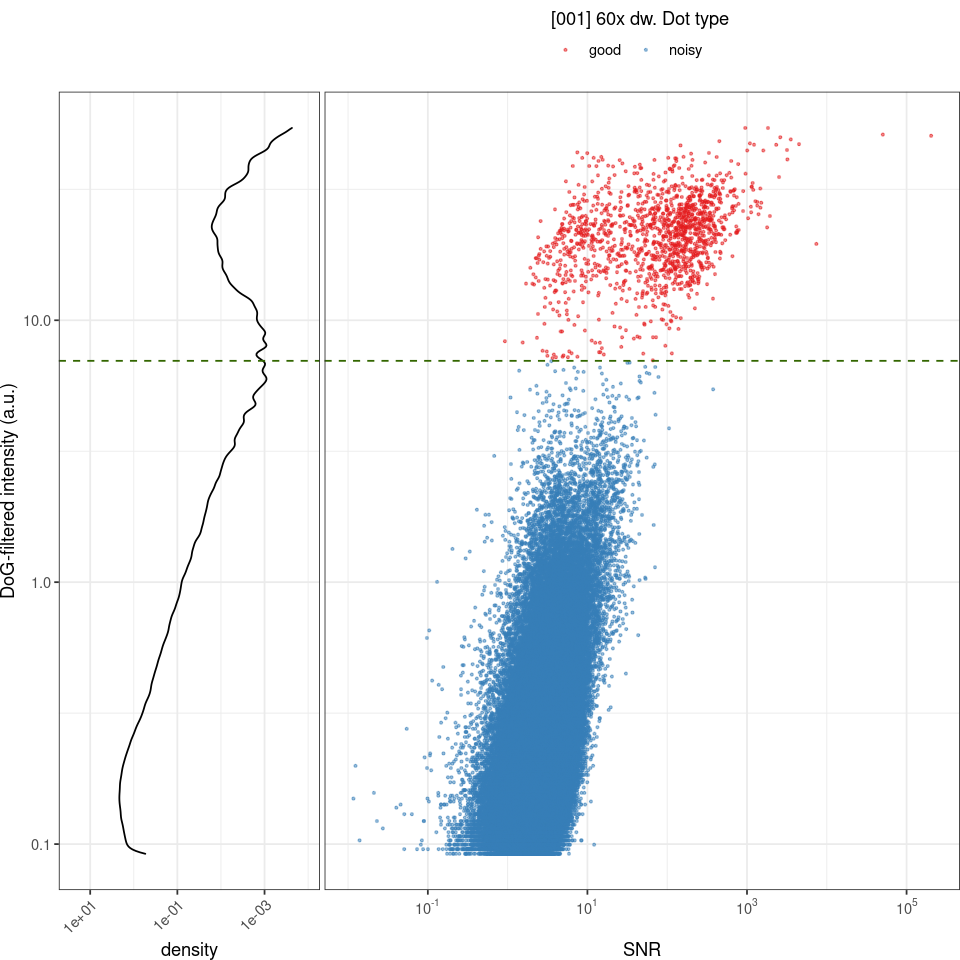

In [5]:
p = plot_scatterplot_with_density_snr_value(dots_data, nuclear_features, "60x", "dw", 1, 7, c(-1, 1, 3, 5))
print(p)

In [6]:
ggsave(plot=p, file="panels/fig_3e.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_3e.rds")

# Panel 3.f
Scatterplot of Value (Y) and SNR (X) for 60x.raw, field 1. Density of Value on the side of Y panel.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



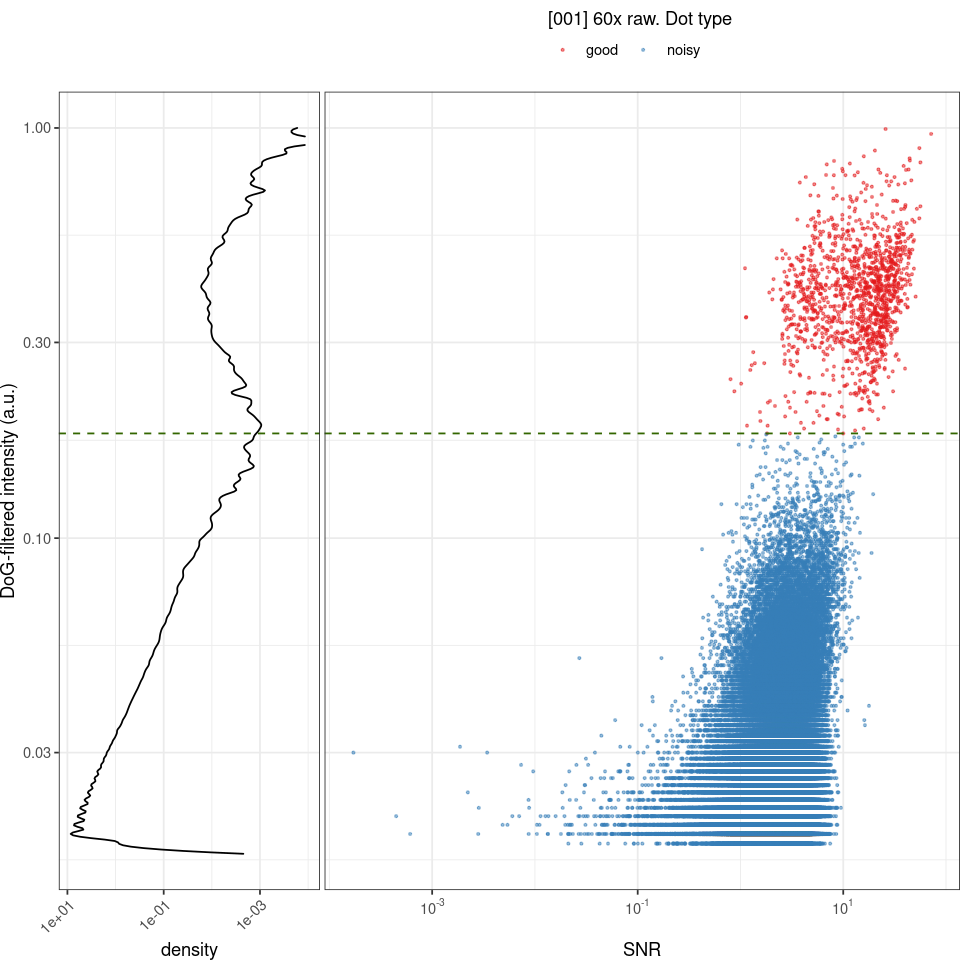

In [7]:
p = plot_scatterplot_with_density_snr_value(dots_data, nuclear_features, "60x", "raw", 1, .18, c(-3, -1, 1), c(.017, 1))
print(p)

In [8]:
ggsave(plot=p, file="panels/fig_3f.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_3f.rds")

# Panel 3.g
Scatterplot of Value (Y) and SNR (X) for 20x.raw, field 1. Density of Value on the side of Y panel.

Warning message:
“Removed 72 rows containing non-finite values (stat_density).”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 72 rows containing non-finite values (stat_density).”
Warning message:
“Removed 72 rows containing missing values (geom_point).”


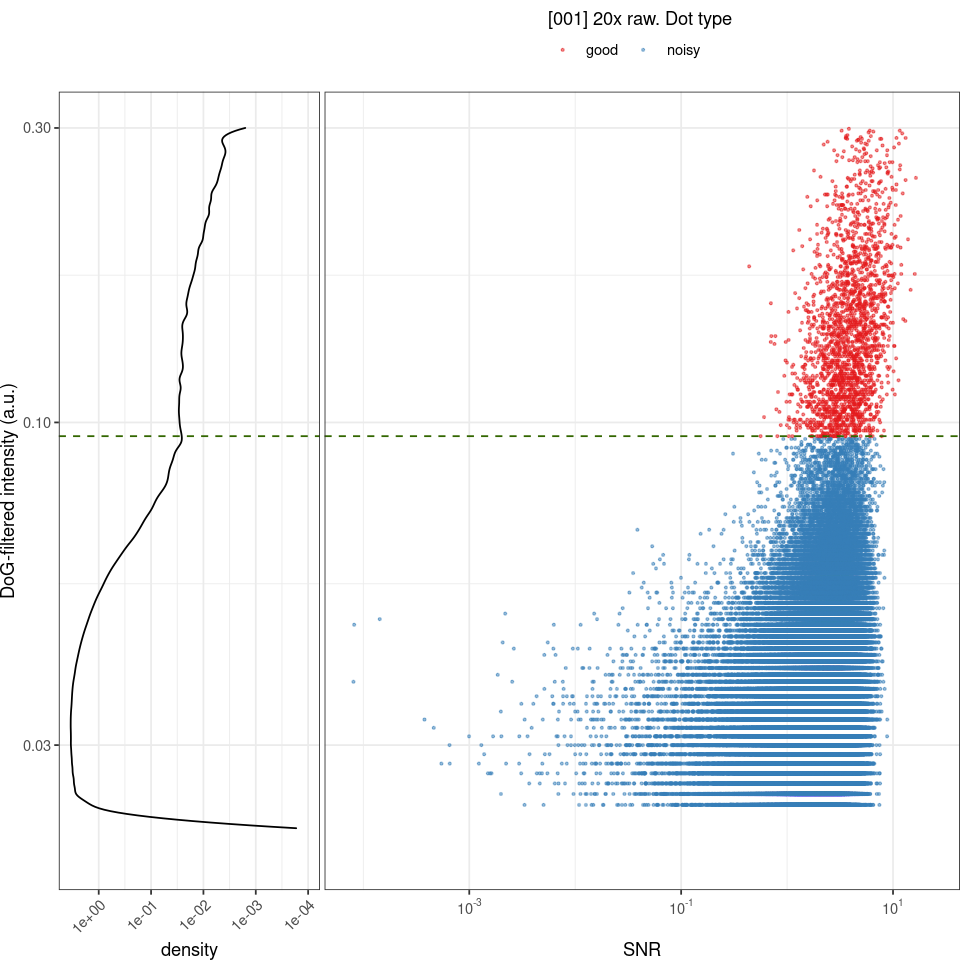

In [9]:
p = plot_scatterplot_with_density_snr_value(dots_data, nuclear_features, "20x", "raw", 1, .095, c(-3, -1, 1), c(.02, .3))
print(p)

In [10]:
ggsave(plot=p, file="panels/fig_3g.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_3g.rds")

# Panel 3.h
Scatterplot of Value (Y) and SNR (X) for 20x.dw, field 1. Density of Value on the side of Y panel.

Warning message:
“Removed 40 rows containing non-finite values (stat_density).”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 40 rows containing non-finite values (stat_density).”
Warning message:
“Removed 40 rows containing missing values (geom_point).”


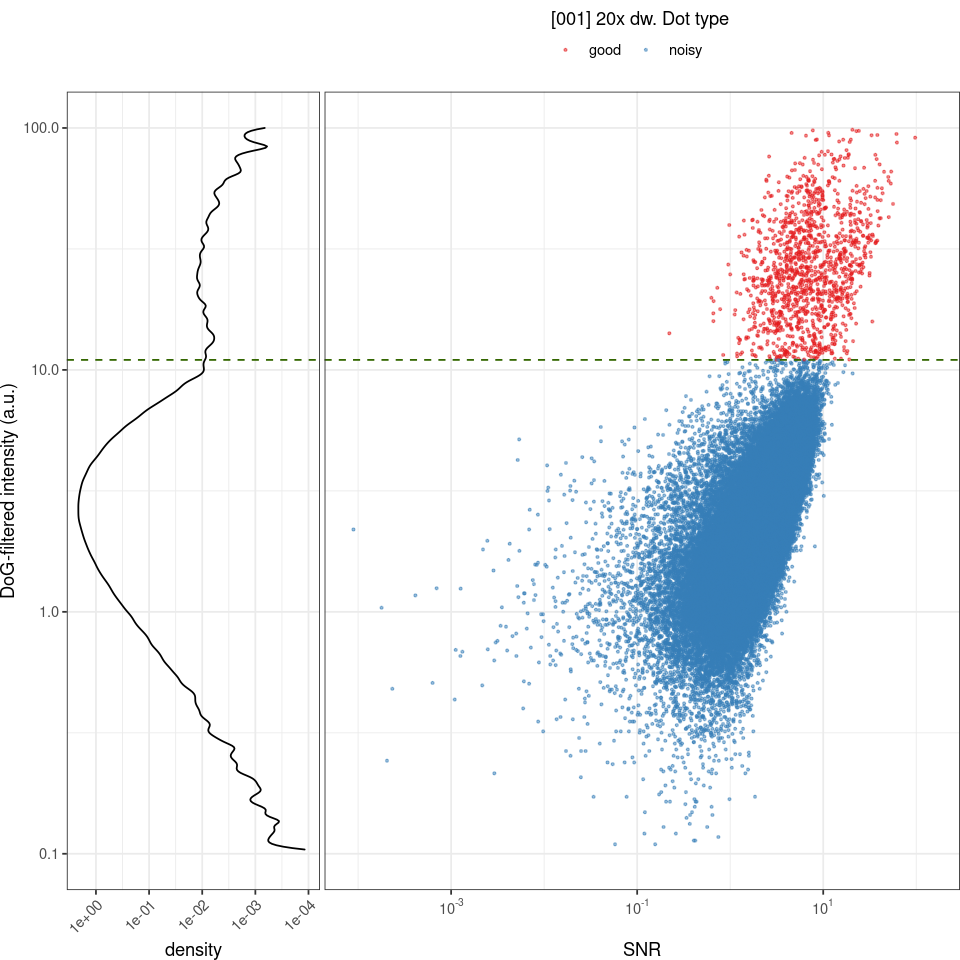

In [11]:
p = plot_scatterplot_with_density_snr_value(dots_data, nuclear_features, "20x", "dw", 1, 11, c(-3, -1, 1), c(.1, 100))
print(p)

In [12]:
ggsave(plot=p, file="panels/fig_3h.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_3h.rds")

# Panel 3.i
Column-plot with dot overlap between 20x.raw and 60x-based reference, by field.

In [13]:
counts_raw = fread("../data/magnifications_matching/20x_raw.matched_dots.field_thr.counts.tsv",
               col.names=c("series_id", "matched", "matched_over_dist", "total_20x", "total_60x")
              )
counts_raw[, image_type := "raw"]

In [14]:
pdata = rbindlist(list(
    counts_raw[, .(series_id, dataset="20x.raw", matched=matched/total_20x)],
    counts_raw[, .(series_id, dataset="Reference", matched=matched/total_60x)]
))
pdata[, unmatched := 1-matched]
pppdata = melt(pdata, id.vars=c("series_id", "dataset"))
pppdata$variable = factor(pppdata$variable, levels=c("unmatched", "matched"))

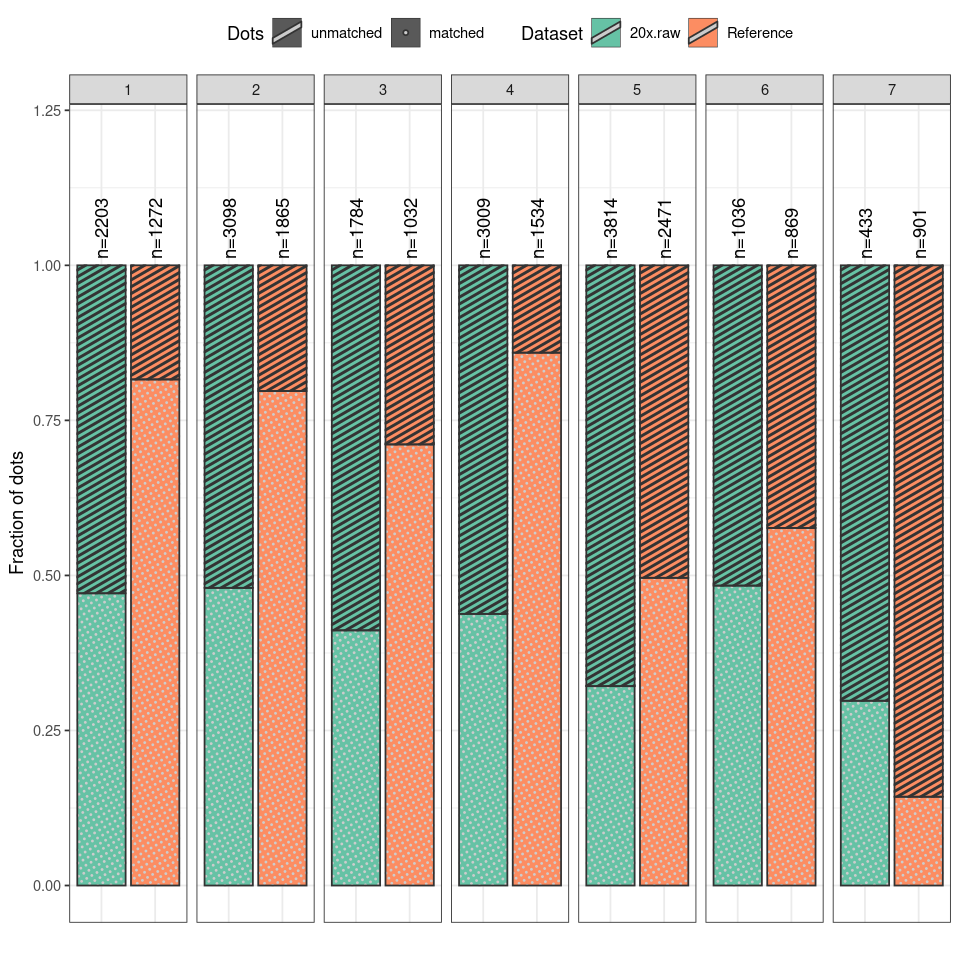

In [15]:
p = ggplot(pppdata, aes(x=dataset, y=value)) +
    geom_col_pattern(aes(fill=dataset, pattern=variable, pattern_color=variable), color="#323232") +
    facet_wrap(~series_id, nrow=1) +
    theme_bw() + theme(legend.position="top", axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
    scale_fill_brewer("Dataset",  palette="Set2") + scale_pattern_color_grey() +
    labs(x="", y="Fraction of dots", pattern="Dots") +
    geom_text(data=counts_raw, aes(x="20x.raw", y=1.01, label=paste0("n=", total_20x)), angle=90, hjust=0, vjust=.5) +
    geom_text(data=counts_raw, aes(x="Reference", y=1.01, label=paste0("n=", total_60x)), angle=90, hjust=0, vjust=.5) +
    coord_cartesian(ylim=c(0, 1.2)) + guides(pattern_color="none")
print(p)

In [16]:
ggsave(plot=p, file="panels/fig_3i.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_3i.rds")

# Panel 3.j
Column-plot with dot overlap between 20x.dw and 60x-based reference, by field.

In [17]:
counts_dw = fread("../data/magnifications_matching/20x_dw.matched_dots.field_thr.counts.tsv",
               col.names=c("series_id", "matched", "matched_over_dist", "total_20x", "total_60x"))
counts_dw[, image_type := "dw"]

In [18]:
pdata = rbindlist(list(
    counts_dw[, .(series_id, dataset="20x.dw", matched=matched/total_20x)],
    counts_dw[, .(series_id, dataset="Reference", matched=matched/total_60x)]
))
pdata[, unmatched := 1-matched]
pppdata = melt(pdata, id.vars=c("series_id", "dataset"))
pppdata$variable = factor(pppdata$variable, levels=c("unmatched", "matched"))

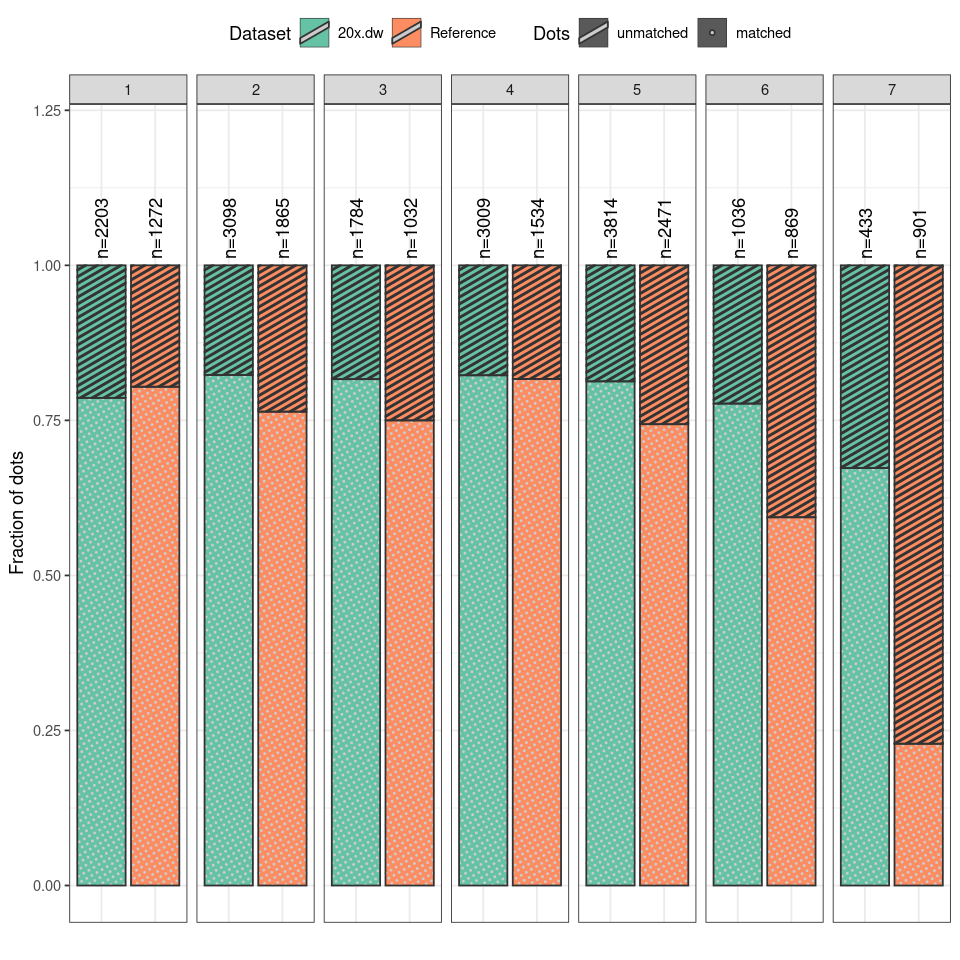

In [19]:
p = ggplot(pppdata, aes(x=dataset, y=value)) +
    geom_col_pattern(aes(fill=dataset, pattern=variable, pattern_color=variable), color="#323232") +
    facet_wrap(~series_id, nrow=1) +
    theme_bw() + theme(legend.position="top", axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
    scale_fill_brewer("Dataset",  palette="Set2") + scale_pattern_color_grey() +
    labs(x="", y="Fraction of dots", pattern="Dots") +
    geom_text(data=counts_raw, aes(x="20x.dw", y=1.01, label=paste0("n=", total_20x)), angle=90, hjust=0, vjust=.5) +
    geom_text(data=counts_raw, aes(x="Reference", y=1.01, label=paste0("n=", total_60x)), angle=90, hjust=0, vjust=.5) +
    coord_cartesian(ylim=c(0, 1.2)) + guides(pattern_color="none")
print(p)

In [20]:
ggsave(plot=p, file="panels/fig_3j.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_3j.rds")